In [1]:
import pyodbc
import pandas as pd
server = 'tcp:fypscm.database.windows.net,1433'
database = 'SCMdb'
username = 'jl2804'
password = 'TauJun2804'
driver= '{ODBC Driver 17 for SQL Server}'

In [2]:
cnxn = pyodbc.connect("Driver="+driver+";Server="+server+";Database="+database+";Uid="+username+";Pwd="+password+";Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;")
cnxn.cursor().cancel()
cursor = cnxn.cursor()
sql="SET NOCOUNT ON EXEC [dbo].[prc_getsalesbymonth] "

#cursor.execute(sql)

data = pd.read_sql(sql,cnxn)
data.to_csv("test1.csv",index=False)
data

,product_id,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,unit_cost,lead_time,retail_price,quantity_on_hand
0,pr1,485,487,561,677,773,850,873,794,736,660,668,533,9.0,10,10.0,2903
1,pr2,1733,1801,2473,2692,2872,3201,3362,2894,2713,2551,2634,1986,6.0,10,10.0,1069688


In [4]:
%matplotlib inline

import matplotlib
import pandas as pd
import seaborn as sns
from supplychainpy.model_inventory import analyse
from supplychainpy.model_demand import *
from supplychainpy.sample_data.config import ABS_FILE_PATH
from decimal import Decimal
raw_df =pd.read_csv("test1.csv")
raw_df['backlog']=10
raw_df.head()

,product_id,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,unit_cost,lead_time,retail_price,quantity_on_hand,backlog
0,pr1,485,487,561,677,773,850,873,794,736,660,668,533,9.0,10,10.0,2903,10
1,pr2,1733,1801,2473,2692,2872,3201,3362,2894,2713,2551,2634,1986,6.0,10,10.0,1069688,10


In [5]:
analyse_kv =dict(
    df=raw_df, 
    start=1, 
    interval_length=12, 
    interval_type='months',
    z_value=Decimal(1.28), 
    reorder_cost=Decimal(400), 
    retail_price=Decimal(455), 
    file_type='csv',
    currency='MYR'
)
analysis_df = analyse( **analyse_kv)
print(analysis_df[['sku', 'excess_stock', 'shortages', 'ABC_XYZ_Classification']])

   sku excess_stock shortages ABC_XYZ_Classification
0  pr1            0         0                     CX
1  pr2      1051405         0                     AX


In [6]:
analysis_rev = analysis_df[['sku', 'revenue']]
print(analysis_rev.sort_values(by='revenue', ascending=True))

   sku revenue
1  pr2  309120
0  pr1   80970


In [9]:
row_ds = raw_df[raw_df['product_id']=='pr1'].squeeze()
print(row_ds[1:12])

jan    485
feb    487
mar    561
apr    677
may    773
jun    850
jul    873
aug    794
sep    736
oct    660
nov    668
Name: 0, dtype: object


In [10]:
ses_df = simple_exponential_smoothing_forecast(ds=row_ds[1:12], length=12, smoothing_level_constant=0.5)
print(ses_df)

{'forecast_breakdown': [{'alpha': 0.5, 't': 1, 'demand': 485, 'level_estimates': 586.3181818181818, 'one_step_forecast': 687.6363636363636, 'forecast_error': -202.63636363636363, 'squared_error': 41061.49586776859}, {'alpha': 0.5, 't': 2, 'demand': 487, 'level_estimates': 536.6590909090909, 'one_step_forecast': 586.3181818181818, 'forecast_error': -99.31818181818176, 'squared_error': 9864.10123966941}, {'alpha': 0.5, 't': 3, 'demand': 561, 'level_estimates': 548.8295454545455, 'one_step_forecast': 536.6590909090909, 'forecast_error': 24.340909090909122, 'squared_error': 592.4798553719023}, {'alpha': 0.5, 't': 4, 'demand': 677, 'level_estimates': 612.9147727272727, 'one_step_forecast': 548.8295454545455, 'forecast_error': 128.1704545454545, 'squared_error': 16427.66541838842}, {'alpha': 0.5, 't': 5, 'demand': 773, 'level_estimates': 692.9573863636364, 'one_step_forecast': 612.9147727272727, 'forecast_error': 160.08522727272725, 'squared_error': 25627.27999096074}, {'alpha': 0.5, 't': 6,

In [11]:
forecast_breakdown_df = pd.DataFrame(ses_df.get('forecast_breakdown', 'UNKNOWN'))
print(forecast_breakdown_df.head)

<bound method NDFrame.head of     alpha   t  demand  level_estimates  one_step_forecast  forecast_error  \
0     0.5   1     485       586.318182         687.636364     -202.636364   
1     0.5   2     487       536.659091         586.318182      -99.318182   
2     0.5   3     561       548.829545         536.659091       24.340909   
3     0.5   4     677       612.914773         548.829545      128.170455   
4     0.5   5     773       692.957386         612.914773      160.085227   
5     0.5   6     850       771.478693         692.957386      157.042614   
6     0.5   7     873       822.239347         771.478693      101.521307   
7     0.5   8     794       808.119673         822.239347      -28.239347   
8     0.5   9     736       772.059837         808.119673      -72.119673   
9     0.5  10     660       716.029918         772.059837     -112.059837   
10    0.5  11     668       692.014959         716.029918      -48.029918   

    squared_error  
0    41061.495868  
1    

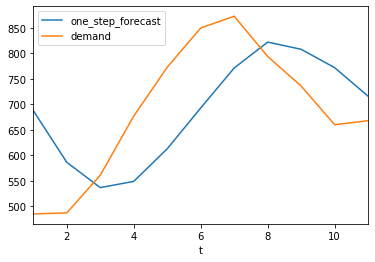

In [12]:
forecast_breakdown_df.plot(x='t', y=['one_step_forecast','demand'])

In [13]:
regression = {'regression': [(ses_df.get('statistics')['slope']* i ) + ses_df.get('statistics')['intercept'] for i in range(1,12)]}
print(regression)

{'regression': [549.2, 580.4, 611.6, 642.8, 674.0, 705.2, 736.4, 767.6, 798.8, 830.0, 861.2]}


In [15]:
row_ds = raw_df[raw_df['product_id']=='pr2'].squeeze()
print(row_ds[1:12])

jan    1733
feb    1801
mar    2473
apr    2692
may    2872
jun    3201
jul    3362
aug    2894
sep    2713
oct    2551
nov    2634
Name: 1, dtype: object


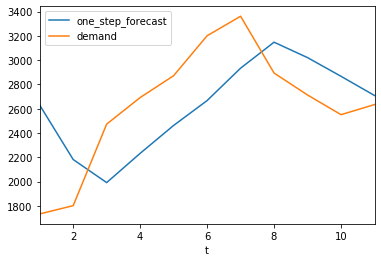

In [17]:
ses_df = simple_exponential_smoothing_forecast(ds=row_ds[1:12], length=12, smoothing_level_constant=0.5)
forecast_breakdown_df = pd.DataFrame(ses_df.get('forecast_breakdown', 'UNKNOWN'))
forecast_breakdown_df.plot(x='t', y=['one_step_forecast','demand'])

In [38]:
cursor = cnxn.cursor()
sql="select * from vendor_order v,warehouse w where v.stock_id=w.stock_id and prod_id='pr2'  "
data = pd.read_sql(sql,cnxn)
data.head()


,Stock_id,Vendor_id,Quantity,Send_date,Receive_date,Sell_price,stock_id,prod_id,date_received,condition,unit_cost,init_quantity
0,sk2,V180101001,49.0,2018-01-06,2018-01-14,10.0,sk2,pr2,2019-06-20 04:00:00,b,8.0,500.0
1,sk2,V180101001,64.0,2018-01-10,2018-01-18,10.0,sk2,pr2,2019-06-20 04:00:00,b,8.0,500.0
2,sk2,V180101001,48.0,2018-01-11,2018-01-19,10.0,sk2,pr2,2019-06-20 04:00:00,b,8.0,500.0
3,sk2,V180101001,81.0,2018-01-15,2018-01-23,10.0,sk2,pr2,2019-06-20 04:00:00,b,8.0,500.0
4,sk2,V180101001,47.0,2018-01-17,2018-01-25,10.0,sk2,pr2,2019-06-20 04:00:00,b,8.0,500.0


In [44]:
data[['Send_date','Quantity']]

,Send_date,Quantity
0,2018-01-06,49.0
1,2018-01-10,64.0
2,2018-01-11,48.0
3,2018-01-15,81.0
4,2018-01-17,47.0
5,2018-01-20,63.0
6,2018-01-27,51.0
7,2018-01-29,55.0
8,2018-02-01,41.0
9,2018-02-02,76.0


In [ ]:
pip install pyramid-arima